# Encontrando los valores de los elementos

## Polinomio Característico

El polinomio característico encontrado es
$$
0 = r^2 + 186 * r + 36205
$$

Dado el circuito propuesto, el polinomio está dado por 
$$
0 = r^2 + V_0 * \left (\frac{1}{C_1*R_1} +\frac{1}{C_1*R_2}-\frac{R_3}{R_2*R_4*C_2}\right ) + \frac{1}{R_1 R_2 C_1 C_2}
$$

Vamos a definir

$$
\alpha = 186 \wedge \beta = 36205
$$

## Valores

Para los capacitores usaremos la serie **E12 (10%)** y para los resistores **E24 (5%)**

Obteniendo los valores posibles de [LogWell](https://www.logwell.com/tech/components/resistor_values.html)

A su vez poseemos restricciones dadas por el enunciado
 - Capacitores entre $1 nF$ y $1 \mu F$
 - Resistores entre $1 k \Omega$ y $1 M \Omega$

## Programación

Comenzamos haciendo los imports y definición de constantes

In [1]:
from decimal import Decimal
from collections import namedtuple
from itertools import product

# Constantes
ALPHA = 186
BETA = 36205
# Limites de los elementos
min_cap = 1e-9
max_cap = 1e-6
min_res = 1e3
max_res = 1e6
# Series de los elementos
cap_set = [100,120,150,180,220,270,330,390,470,560,680,820]
res_set = [100,110,120,130,150,160,180,200,220,240,270,300,330,360,390,430,470,510,560,620,680,750,820,910]

Components = namedtuple('components', ('r1', 'r2', 'r3', 'r4', 'c1', 'c2', 'alfa', 'err_alfa', 'beta', 'err_beta', 'err_r'))

In [2]:
from ipywidgets import IntProgress
from IPython.display import display
from time import time

from multiprocessing import Manager, Pool

Se definen algunas funciones auxiliares

In [3]:
def fexp(number):
    """
    Dado un numero, devuelve el exponente en base 10 del mismo
    """
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

# Validadores de valores
def check_res(r):
    """
    Verifica si una resistencia se encuentra entre los valores permitidos
    """
    return min_res <= r <= max_res


def check_cap(c):
    """
    Verifica si un capacitor se encuentra entre los valores permitidos
    """
    return min_cap <= c <= max_cap

Se define una función para obtener todos los valores posibles de un determinado componente, dada una serie determinada y los límites datos

In [4]:
def value_yielder(base, serie_value, exp, check_func):
    """
    Dada una valor deserie y un exponente inicial, se buscan todos los valores de multiplicadores
        (..., 0.01, 0.1, 1, 10, 100, ...)
    que estén dentro de los valores permitidos.
    Para ello se usa una base que se espera sea 1 o -1 para ver si se debe aumentar o disminuir
    el multiplicador
    Ejemplos:
        base = 1
        serie_value = 10
        exp = 10^-9

        Se prueba: 10^-9, 10^-8, 10^-7, ...

    En cambio si base = -1:
        10^-9, 10^-10, 10^-11, ...
    """
    n = 0
    while True:
        new_base = base * n
        multi = 10 ** new_base
        num = serie_value * exp * multi
        if check_func(num):
            yield num
            n += 1
        else:
            break


def get_valid_element(min_val, series, check_func):
    # Tomo como referencia el valor minimo permitido y tomo su exponente como base
    exp = 10**fexp(min_val)

    # Primero itero por los valores de las series
    for serie_value in series:
        # Empiezo con multiplicadores negativos
        for value in value_yielder(base=-1, serie_value=serie_value, exp=exp, check_func=check_func):
            yield value

        # Sigo con multiplicadores positivos
        for value in value_yielder(base=1, serie_value=serie_value, exp=exp, check_func=check_func):
            yield value

Luego se hace función de fuerza bruta entre todas las posibilidades y sólo se toman como valores posibles aquellos que en los cálculos de $\frac{Q}{\omega}$ y $\omega$ arrojen un error menor al 10%

In [5]:
def brute_force(valid_caps, valid_res):
    """
    Capacitores: c1, c2
    Resistores: r1, r2, r3, r4
    """
    # Para acortar
    c = valid_caps
    r = valid_res
    
    total_pos = len(valid_caps)**2 * len(valid_res)**4
    progress_bar = IntProgress(min=0, max=total_pos)
    display(progress_bar)
    last_update = time()
    count = 0
    
    # Para minimizar trabajo primero me fijo que valores de r1 r2 c1 c2 me dan un beta aceptable
    gen_values = product(r, r, c, c)
    
    for r1, r2, c1, c2 in gen_values:
        # Calculo beta
        calc_beta = 1/(r1*r2*c1*c2)
        err_beta = abs(calc_beta - BETA) / BETA
        
        if err_beta <= 0.1:
            # Estos valores son aceptables, ahora debo buscar r3, r4
            for r3, r4 in product(r, r):
                # Calculo alfa
                calc_alfa = (1/(c1*r1))+(1/(c1*r2))-(r3/(r2*r4*c2))
                err_alfa = abs(calc_alfa - ALPHA) / ALPHA
                
                # Calculo el cociente entre las resistencias
                r_cos = r3 / r4
                err_r = abs(r_cos - 349) / 349
                
                if err_alfa <= 0.1 and err_r <= 0.1:
                    # Es aceptable
                    comp = Components(c1=c1, c2=c2, r1=r1, r2=r2, r3=r3, r4=r4, alfa=calc_alfa, err_alfa=err_alfa, beta=calc_beta, err_beta=err_beta, err_r=err_r)
                    yield comp, max(err_alfa, err_beta, err_r)
                count += 1
                now = time()
                if now - last_update >= 2.0:
                    progress_bar.value += count
                    last_update = now
                    count = 0
                    
        else:
            # No son aceptables, salteo
            # Avanzo el contador equivalente al producto de 2 resistencias
            count += len(valid_res)**2
            
        now = time()
        if now - last_update >= 2.0:
            progress_bar.value += count
            last_update = now
            count = 0
"""
    for c1, c2, r1, r2, r3, r4 in gen_values:
        # Calculo alfa
        calc_alfa = (1/(c1*r1))+(1/(c1*r2))-(r3/(r2*r4*c2))
        err_alfa = abs(calc_alfa - ALPHA) / ALPHA
        
        # Calculo beta
        calc_beta = 1/(r1*r2*c1*c2)
        err_beta = abs(calc_beta - BETA) / BETA
        
        if err_alfa <= 0.1 and err_beta <= 0.1:
            comp = Components(c1=c1, c2=c2, r1=r1, r2=r2, r3=r3, r4=r4, alfa=calc_alfa, err_alfa=err_alfa, beta=calc_beta, err_beta=err_beta)
            yield comp, max(err_alfa, err_beta)
        
        count += 1
        now = time()
        if now - last_update >= 2.0:
            progress_bar.value += count
            last_update = now
            count = 0
"""

'\n    for c1, c2, r1, r2, r3, r4 in gen_values:\n        # Calculo alfa\n        calc_alfa = (1/(c1*r1))+(1/(c1*r2))-(r3/(r2*r4*c2))\n        err_alfa = abs(calc_alfa - ALPHA) / ALPHA\n        \n        # Calculo beta\n        calc_beta = 1/(r1*r2*c1*c2)\n        err_beta = abs(calc_beta - BETA) / BETA\n        \n        if err_alfa <= 0.1 and err_beta <= 0.1:\n            comp = Components(c1=c1, c2=c2, r1=r1, r2=r2, r3=r3, r4=r4, alfa=calc_alfa, err_alfa=err_alfa, beta=calc_beta, err_beta=err_beta)\n            yield comp, max(err_alfa, err_beta)\n        \n        count += 1\n        now = time()\n        if now - last_update >= 2.0:\n            progress_bar.value += count\n            last_update = now\n            count = 0\n'

Por último se hace uso de todos los datos y funciones; se analiza la respuesta de la fuerza bruta y nos quedamos con aquellos resultados cuyo máximo error sea el mínimo del conjunto

In [6]:
def resolver():
    valid_caps = set(get_valid_element(min_cap, cap_set, check_cap))
    valid_res = set(get_valid_element(min_res, res_set, check_res))
    n_caps = len(valid_caps)
    n_res = len(valid_res)
    print(f"Tenemos {n_caps} valores posibles de capacitores")
    print(f"Tenemos {n_res} valores posibles de resistencias")
    print(f"Tenemos {n_res**4 * n_caps**2} valores posibles totales")

    print('Busco por fuerza bruta')
    valid_res = list(brute_force(valid_caps, valid_res))
    print(f"Tengo {len(valid_res)} posibilidades")
    mejor = min(valid_res, key=lambda x:x[1])
    print(mejor)
    return mejor
    
mejor = resolver()

Tenemos 36 valores posibles de capacitores
Tenemos 73 valores posibles de resistencias
Tenemos 36804120336 valores posibles totales
Busco por fuerza bruta


IntProgress(value=0, max=36804120336)

Tengo 1010 posibilidades
(components(r1=360000, r2=130000, r3=620000, r4=1800.0, c1=1.5000000000000002e-09, c2=3.9e-07, alfa=186.28095551172464, err_alfa=0.001510513503895924, beta=36525.67755131857, err_beta=0.008857272512596912, err_r=0.01305316778096144), 0.01305316778096144)


## Comparación

Ahora compararemos los resultados obtenidos



In [16]:
import matplotlib.pyplot as plt
import numpy as np
import sympy

t = sympy.symbols('t', positive=True)

In [34]:
def get_func(coefs, scale=1000):
    # Devuelve la función en base a los coeficientes del polinomio
    roots = np.roots(coefs)
    # Me quedo con una raiz
    r = roots[0]
    real = r.real
    img = abs(r.imag)
    
    return lambda t: (0.0035 * np.exp(real*t) * (-np.cos(img*t)+np.sin(img*t)) + 0.0035)*scale
    
    

# Defino los coeficients el polinomio característico original
coefs_orig = [1, ALPHA, BETA]
# Defino los coeficients mediante los resultados obtenidos
res = mejor[0]
coefs_calc = [1, res.alfa, res.beta]

f_orig = get_func(coefs_orig)
f_calc = get_func(coefs_calc)

In [36]:
coefs_

[1, 186, 36205]

In [37]:
coefs_calc

[1, 186.28095551172464, 36525.67755131857]

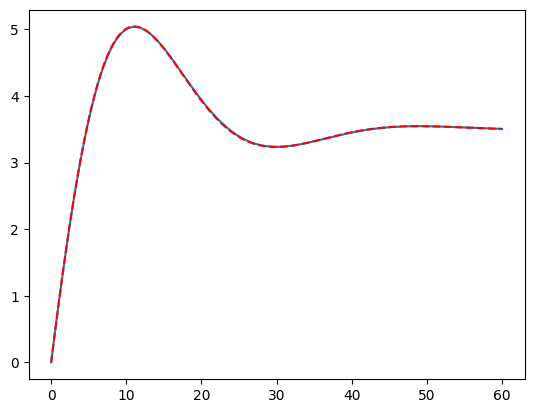

In [41]:
# Graficoa
x = np.linspace(0,60,1000)
    
plt.plot(x, f_orig(x/1000),x,f_calc(x/1000), 'r--')
# show the plot
plt.show()